In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pubchempy as pcp

%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/User/AppData/Local/Programs/VS_Projects/Testing/EcoTeam/files/Density.csv')
df.head(6)

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI)
0,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004
1,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056
2,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056
3,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001
4,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001


In [4]:
df.describe()

,Number of components,I,II,III,IV,V,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3"
count,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,325.000000,4309.000000,4309.000000
mean,2.075424,0.013692,0.000464,0.655372,0.071942,0.337897,0.340917,0.641705,0.224315,320.035424,42.854478
std,0.264104,0.116224,0.021542,0.475302,0.258423,0.473048,0.190665,0.197232,0.262686,20.757705,1201.130102
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034000,0.078000,0.016393,278.150000,0.806000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.500000,0.041683,303.150000,1.000612
50%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.333000,0.667000,0.062500,318.150000,1.090300
75%,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.800000,0.333333,333.150000,1.185486
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.917000,0.950000,0.843000,413.150000,44562.000000


In [5]:
replace_mapper = {'Octyl Paraben': 'octylparaben'}
df.replace(replace_mapper, inplace=True)

In [6]:
def get_smiles(dataset):
    dataset_unique_1 = list(dataset['Component#1'].unique())
    dataset_unique_2 = list(dataset['Component#2'].unique())
    dataset_unique_1.extend(dataset_unique_2)
    dataset_unique = list(set(dataset_unique_1))

    smiles_dict = {}

    for compound in dataset_unique:
        compounds = pcp.get_compounds(compound, 'name')

        try:
            mol = compounds[0]
            smiles_dict[compound] = mol.canonical_smiles
        except:
            print(f'Соединение c названием {compound} не найдено.')
    dataset['SMILES#1'] = dataset['Component#1'].map(smiles_dict)
    dataset['SMILES#2'] = dataset['Component#2'].map(smiles_dict)
    return dataset
    
df = get_smiles(df)
df.head(5)

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),SMILES#1,SMILES#2
0,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-]
1,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-]
2,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-]
3,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-]
4,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-]


## Визуализация данных

Number of components - 0%
Type of DES - 8%
I - 0%
II - 0%
III - 0%
IV - 0%
V - 0%
Component#1 - 0%
Component#2 - 0%
Component#3 - 92%
X#1 (molar fraction) - 0%
X#2 (molar fraction) - 0%
X#3 (molar fraction) - 92%
Temperature, K - 0%
Density, g/cm^3 - 0%
Reference (DOI) - 0%
SMILES#1 - 0%
SMILES#2 - 0%


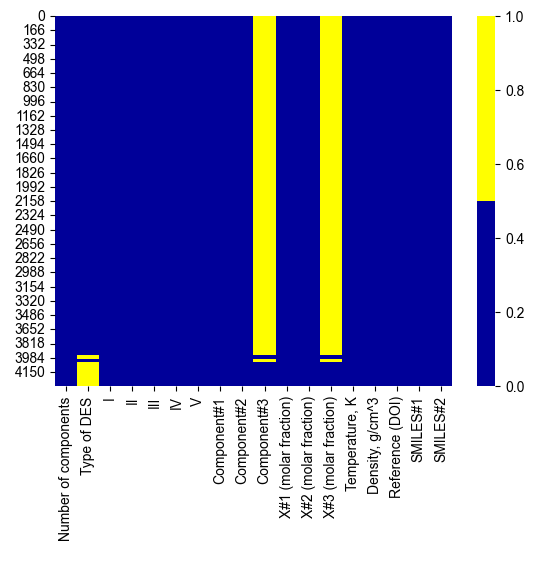

In [7]:
#поиск пустых ячеек
cols = df.columns
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
sns.set(font_scale=0.5)
# процентный список пропущенных данных
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

<Axes: >

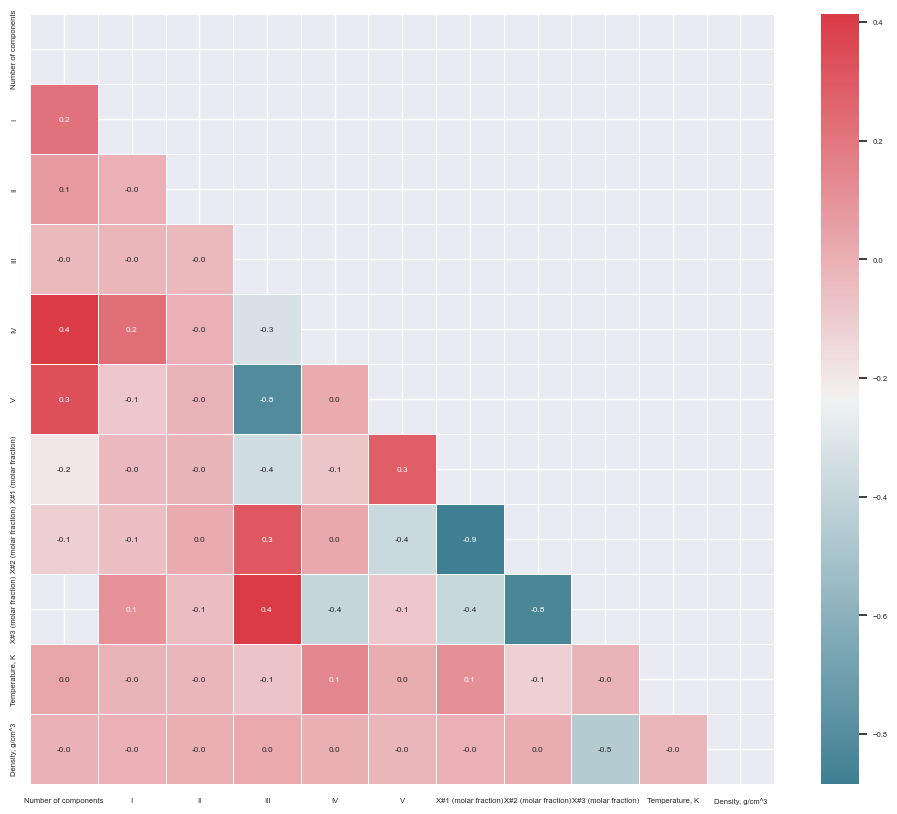

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.tolist()
numeric_df = df[numeric_columns]

#Корреляционная карта
corr = numeric_df.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, linewidths=.5, mask=mask,annot=True, fmt='.1f')